In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm  # Импорт функции напрямую
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from copy import deepcopy

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-05-23 15:04:11.465594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748012651.699125      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748012651.769453      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
DATA_DIR = '/kaggle/input/camvid/CamVid'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [4]:
num_classes = 32
image_size = 384

In [5]:
class_dict = pd.read_csv(DATA_DIR + "/class_dict.csv")
color_mapping = {(row['r'], row['g'], row['b']): idx for idx, row in class_dict.iterrows()}

print(color_mapping)

{(64, 128, 64): 0, (192, 0, 128): 1, (0, 128, 192): 2, (0, 128, 64): 3, (128, 0, 0): 4, (64, 0, 128): 5, (64, 0, 192): 6, (192, 128, 64): 7, (192, 192, 128): 8, (64, 64, 128): 9, (128, 0, 192): 10, (192, 0, 64): 11, (128, 128, 64): 12, (192, 0, 192): 13, (128, 64, 64): 14, (64, 192, 128): 15, (64, 64, 0): 16, (128, 64, 128): 17, (128, 128, 192): 18, (0, 0, 192): 19, (192, 128, 128): 20, (128, 128, 128): 21, (64, 128, 192): 22, (0, 0, 64): 23, (0, 64, 64): 24, (192, 64, 128): 25, (128, 128, 0): 26, (192, 128, 192): 27, (64, 0, 64): 28, (192, 192, 0): 29, (0, 0, 0): 30, (64, 192, 0): 31}


In [6]:
class CamVidDataset(Dataset):
    def __init__(self, image_dir, label_dir, color_mapping, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.color_mapping = color_mapping
        self.transform = transform
        self.image_files = sorted([os.path.join(image_dir, f)
                                   for f in os.listdir(image_dir)
                                   if f.endswith('.png')])
        self.label_files = sorted([os.path.join(label_dir, f)
                                   for f in os.listdir(label_dir)
                                   if f.endswith('.png')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_files[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = cv2.imread(self.label_files[idx])
        label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
        label = self.convert_to_class(label)

        if self.transform:
            augmented = self.transform(image=image, mask=label)
            image = augmented['image']
            label = augmented['mask']

        return image, label.long()

    def convert_to_class(self, label):
        class_mask = np.zeros((label.shape[0], label.shape[1]), dtype=int)

        for rgb, class_idx in self.color_mapping.items():
            mask = (label[:, :, 0] == rgb[0]) & (label[:, :, 1] == rgb[1]) & (label[:, :, 2] == rgb[2])
            class_mask[mask] = class_idx

        return class_mask

In [7]:
def get_transform(train=True):
    if train:
      return A.Compose([
          A.RandomCrop(height=384, width=384, p=0.3),
          A.Resize(image_size, image_size),
          A.HorizontalFlip(p=0.3),
          A.VerticalFlip(p=0.2),
          A.RandomBrightnessContrast(p=0.1),
          A.ColorJitter(p=0.3),
          A.GaussianBlur(p=0.3),
          A.GaussNoise(std_range=[0.1, 0.2], p=0.2),
          A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
          ToTensorV2(),
      ])
    else:
        return A.Compose([
            A.Resize(image_size, image_size),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])

In [8]:
train_dataset = CamVidDataset(
                  x_train_dir,
                  y_train_dir,
                  color_mapping,
                  transform=get_transform(train=True))

val_dataset = CamVidDataset(
                  x_valid_dir,
                  y_valid_dir,
                  color_mapping,
                  transform=get_transform(train=False))

test_dataset = CamVidDataset(
                  x_test_dir,
                  y_test_dir,
                  color_mapping,
                  transform=get_transform(train=False))

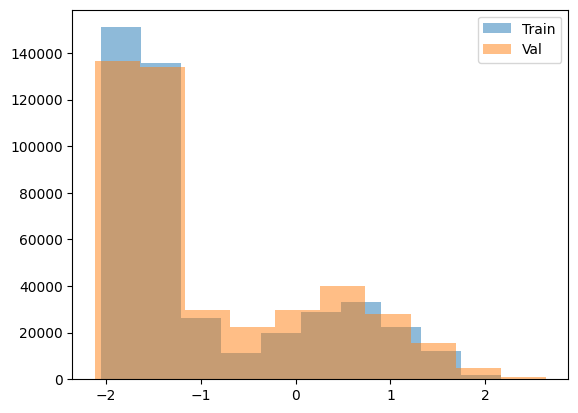

In [9]:
plt.hist(train_dataset[0][0].numpy().ravel(), alpha=0.5, label='Train')
plt.hist(val_dataset[0][0].numpy().ravel(), alpha=0.5, label='Val')
plt.legend()

In [10]:
def denormalize(tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    # Тензор в формате [C, H, W] -> [H, W, C]
    tensor = tensor.permute(1, 2, 0).numpy()
    tensor = tensor * std + mean
    tensor = np.clip(tensor, 0, 1)
    return tensor

In [11]:
def visualize_samples(dataset, color_mapping, num_samples=3):
    reverse_color_mapping = {v: k for k, v in color_mapping.items()}

    fig, axs = plt.subplots(num_samples, 2, figsize=(10, 5*num_samples))

    for i in range(num_samples):
        image, label = dataset[i]
        image = denormalize(image)
        label = label.numpy()


        label_rgb = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)
        for class_idx, rgb in reverse_color_mapping.items():
            label_rgb[label == class_idx] = rgb

        axs[i, 0].imshow(image)
        axs[i, 0].set_title(f'Sample {i + 1} - Image')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(label_rgb)
        axs[i, 1].set_title(f'Sample {i + 1} - Label')
        axs[i, 1].axis('off')


    plt.tight_layout()
    plt.show()

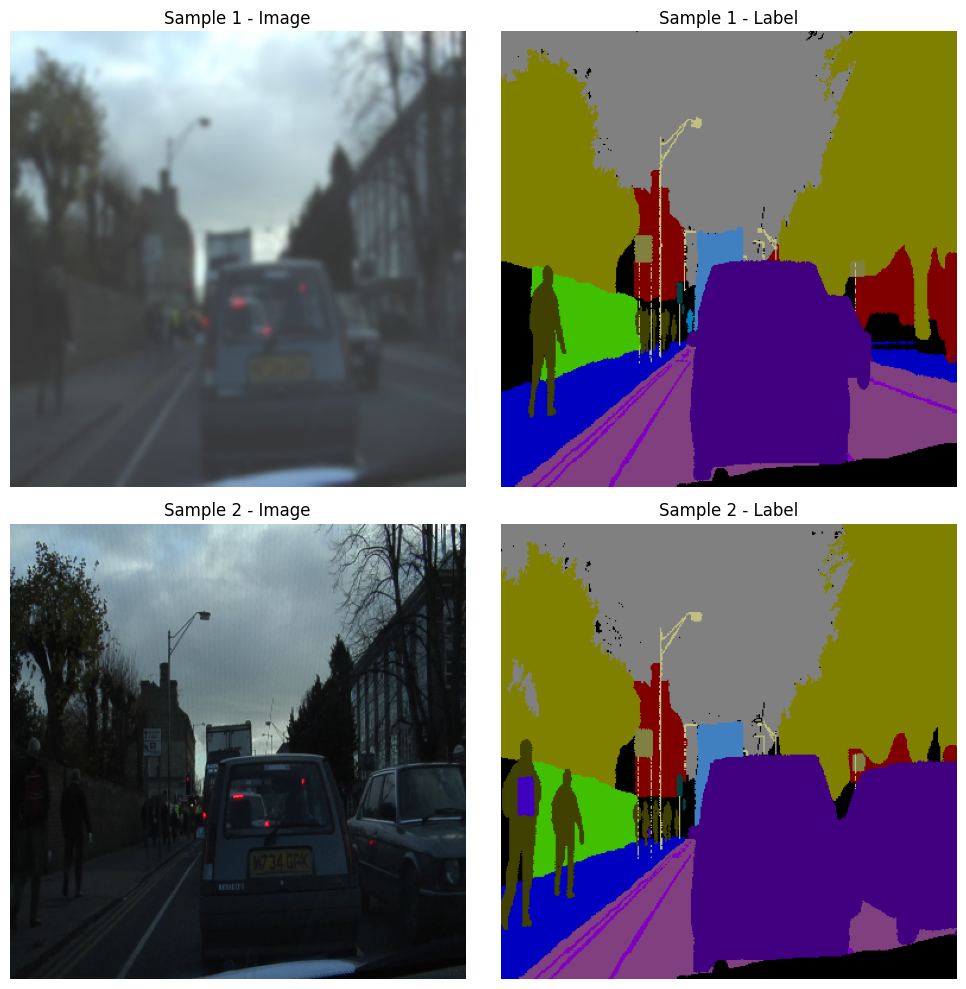

In [12]:
visualize_samples(train_dataset,color_mapping, num_samples=2)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=4,
                          shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4,
                        shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4,
                         shuffle=False, num_workers=4)

In [14]:
from torchvision.models.segmentation import fcn_resnet50

model = fcn_resnet50(pretrained=True)

model.classifier = torch.nn.Sequential(
    torch.nn.Conv2d(2048, num_classes, kernel_size=1)
)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:04<00:00, 31.3MB/s] 


In [15]:
model

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [16]:
def val_epoch(model, dataloader, criterion, device):
    model.eval()

    running_loss = 0.0

    correct_pixels = 0
    total_pixels = 0

    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)

    dice_per_class = np.zeros(num_classes)
    total_counts = np.zeros(num_classes)
    smooth = 1e-6

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Validating", leave=True)

        for images, masks in progress_bar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)["out"]
            loss = criterion(outputs, masks)

            preds = torch.argmax(outputs, dim=1)
            correct_pixels += (preds == masks).sum().item()
            total_pixels += masks.numel()

            # Update confusion matrix
            masks_np = masks.cpu().numpy()
            preds_np = preds.cpu().numpy()
            for pred, mask in zip(preds_np, masks_np):
                conf_matrix += confusion_matrix(mask.flatten(),
                                             pred.flatten(),
                                             labels=np.arange(num_classes))

            # Calculate Dice
            for class_id in range(num_classes):
                true_pos = np.sum((preds_np == class_id) & (masks_np == class_id))
                false_pos = np.sum((preds_np == class_id) & (masks_np != class_id))
                false_neg = np.sum((preds_np != class_id) & (masks_np == class_id))

                dice = (2 * true_pos + smooth) / (2 * true_pos + false_pos + false_neg + smooth)
                dice_per_class[class_id] += dice
                total_counts[class_id] += 1

            running_loss += loss.item()
            progress_bar.set_postfix({"val_loss": f"{loss.item():.4f}"})

    # Calculate final metrics
    epoch_loss = running_loss / len(dataloader)
    pixel_accuracy = correct_pixels / total_pixels

    # Calculate IoU
    intersection = np.diag(conf_matrix)
    union = conf_matrix.sum(axis=1) + conf_matrix.sum(axis=0) - intersection
    iou_per_class = intersection / (union + 1e-8)
    mean_iou = np.nanmean(iou_per_class)

    # Calculate Dice
    dice_per_class /= total_counts
    mean_dice = np.nanmean(dice_per_class)

    return epoch_loss, pixel_accuracy, iou_per_class, mean_iou, dice_per_class, mean_dice

In [17]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()

    running_loss = 0.0

    correct_pixels = 0
    total_pixels = 0

    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)

    progress_bar = tqdm(dataloader, desc="Training", leave=True)

    for images, masks in progress_bar:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)["out"]
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate metrics
        preds = torch.argmax(outputs, dim=1)
        correct_pixels += (preds == masks).sum().item()
        total_pixels += masks.numel()

        # Update confusion matrix
        masks_np = masks.cpu().numpy()
        preds_np = preds.cpu().numpy()
        for pred, mask in zip(preds_np, masks_np):
            conf_matrix += confusion_matrix(mask.flatten(),
                                         pred.flatten(),
                                         labels=np.arange(num_classes))

        running_loss += loss.item()
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    # Calculate final metrics
    epoch_loss = running_loss / len(dataloader)
    pixel_accuracy = correct_pixels / total_pixels

    # Calculate IoU
    intersection = np.diag(conf_matrix)
    union = conf_matrix.sum(axis=1) + conf_matrix.sum(axis=0) - intersection
    iou_per_class = intersection / (union + 1e-8)
    mean_iou = np.nanmean(iou_per_class)

    return epoch_loss, pixel_accuracy, iou_per_class, mean_iou

In [18]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001, mode='max'):
        self.patience = patience
        self.delta = delta
        self.mode = mode
        self.counter = 0
        self.best_score = -np.inf if mode == 'max' else np.inf
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, current_score, model):
        if self.mode == 'max':
            if current_score > self.best_score + self.delta:
                self.best_score = current_score
                self.counter = 0
                self.best_model_state = deepcopy(model.state_dict())
            else:
                self.counter += 1
                print(f"Early stopping patience: {self.counter}/{self.patience}")
        else:
            if current_score < self.best_score - self.delta:
                self.best_score = current_score
                self.counter = 0
                self.best_model_state = deepcopy(model.state_dict())
            else:
                self.counter += 1
                print(f"Early stopping patience: {self.counter}/{self.patience}")

        if self.counter >= self.patience:
            self.early_stop = True

In [19]:
early_stopping = EarlyStopping(
    patience=20,
    mode='max',
    delta=0.001
)

In [37]:
def save_checkpoint(model, optimizer, history, epoch, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history,
        'best_score': early_stopping.best_score,
        'early_stopping_counter': early_stopping.counter
    }, path)

def load_checkpoint(path, model, optimizer):
    checkpoint = torch.load(path, weights_only=False)  # Явно указываем weights_only=False
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    history = checkpoint['history']
    return epoch, history

In [38]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
               device, num_classes, num_epochs=10,
               initial_epoch=0, history=None):
    if history == None:
        history = {
            'train_loss': [], 'train_acc': [], 'train_iou': [],
            'val_loss': [], 'val_acc': [], 'val_iou': [], 'val_dice': []
        }

    for epoch in range(initial_epoch, num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Training
        train_loss, train_acc, train_iou_per_class, train_mean_iou = train_epoch(
            model, train_loader, criterion, optimizer, device)

        # Validation
        val_loss, val_acc, val_iou_per_class, val_mean_iou, val_dice_per_class, val_mean_dice = val_epoch(
            model, val_loader, criterion, device)

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_iou'].append(train_mean_iou)

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_iou'].append(val_mean_iou)
        history['val_dice'].append(val_mean_dice)

        # Print epoch summary
        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | mIoU: {train_mean_iou:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | mIoU: {val_mean_iou:.4f} | Dice: {val_mean_dice:.4f}")

        # Early Stopping check
        early_stopping(val_mean_iou, model)

        # Saving checkpoints
        checkpoint_path = f"checkpoint_epoch_{epoch+1}.pth"
        save_checkpoint(
            model=model,
            optimizer=optimizer,
            history=history,
            epoch=epoch,
            path=checkpoint_path
        )

        # Or save only the best model
        if early_stopping.best_score == val_mean_iou:  # Changed to val_loss for better model selection
            save_checkpoint(
                model=model,
                optimizer=optimizer,
                history=history,
                epoch=epoch,
                path="best_model.pth"
            )

        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    return history


In [40]:
early_stopping = EarlyStopping(
    patience=20,
    mode='max',
    delta=0.001
)

In [41]:
# Загрузка сохраненного состояния
loaded_epoch, loaded_history = load_checkpoint(
    path="best_model.pth",  # или другой путь к чекпоинту
    model=model,
    optimizer=optimizer
)

# Продолжение обучения с загруженного состояния
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_classes=num_classes,
    num_epochs=50,
    initial_epoch=loaded_epoch + 1,
    history=loaded_history
)


Epoch 35/50


Validating: 100%|██████████| 25/25 [00:09<00:00,  2.65it/s, val_loss=0.3946]


Train Loss: 0.2814 | Acc: 0.9047 | mIoU: 0.4611
Val Loss: 0.3175 | Acc: 0.8972 | mIoU: 0.4277 | Dice: 0.7181

Epoch 36/50


Validating: 100%|██████████| 25/25 [00:09<00:00,  2.64it/s, val_loss=0.3664]


Train Loss: 0.2912 | Acc: 0.9017 | mIoU: 0.4725
Val Loss: 0.3215 | Acc: 0.8958 | mIoU: 0.4250 | Dice: 0.6945
Early stopping patience: 1/20

Epoch 37/50


Validating: 100%|██████████| 25/25 [00:09<00:00,  2.69it/s, val_loss=0.3692]


Train Loss: 0.2778 | Acc: 0.9048 | mIoU: 0.4769
Val Loss: 0.3142 | Acc: 0.8988 | mIoU: 0.4391 | Dice: 0.7131

Epoch 38/50


Validating: 100%|██████████| 25/25 [00:09<00:00,  2.69it/s, val_loss=0.3742]


Train Loss: 0.2836 | Acc: 0.9025 | mIoU: 0.4824
Val Loss: 0.3134 | Acc: 0.8979 | mIoU: 0.4331 | Dice: 0.7026
Early stopping patience: 1/20

Epoch 39/50


Validating: 100%|██████████| 25/25 [00:09<00:00,  2.69it/s, val_loss=0.3839]


Train Loss: 0.2886 | Acc: 0.9009 | mIoU: 0.4757
Val Loss: 0.3205 | Acc: 0.8980 | mIoU: 0.4358 | Dice: 0.6984
Early stopping patience: 2/20

Epoch 40/50


Validating: 100%|██████████| 25/25 [00:09<00:00,  2.72it/s, val_loss=0.3846]


Train Loss: 0.2826 | Acc: 0.9039 | mIoU: 0.4884
Val Loss: 0.3163 | Acc: 0.8968 | mIoU: 0.4259 | Dice: 0.6894
Early stopping patience: 3/20

Epoch 41/50


Validating: 100%|██████████| 25/25 [00:09<00:00,  2.73it/s, val_loss=0.3728]


Train Loss: 0.2789 | Acc: 0.9038 | mIoU: 0.4833
Val Loss: 0.3077 | Acc: 0.8989 | mIoU: 0.4449 | Dice: 0.6998

Epoch 42/50


Validating: 100%|██████████| 25/25 [00:09<00:00,  2.70it/s, val_loss=0.3687]


Train Loss: 0.2880 | Acc: 0.9013 | mIoU: 0.4847
Val Loss: 0.3104 | Acc: 0.8996 | mIoU: 0.4440 | Dice: 0.7072
Early stopping patience: 1/20

Epoch 43/50


Validating: 100%|██████████| 25/25 [00:09<00:00,  2.55it/s, val_loss=0.3464]


Train Loss: 0.2884 | Acc: 0.9025 | mIoU: 0.4795
Val Loss: 0.3100 | Acc: 0.9009 | mIoU: 0.4381 | Dice: 0.7136
Early stopping patience: 2/20

Epoch 44/50


Validating: 100%|██████████| 25/25 [00:09<00:00,  2.56it/s, val_loss=0.3702]


Train Loss: 0.2714 | Acc: 0.9062 | mIoU: 0.4907
Val Loss: 0.3094 | Acc: 0.8994 | mIoU: 0.4419 | Dice: 0.7080
Early stopping patience: 3/20

Epoch 45/50


Validating: 100%|██████████| 25/25 [00:09<00:00,  2.68it/s, val_loss=0.3994]


Train Loss: 0.2786 | Acc: 0.9041 | mIoU: 0.4951
Val Loss: 0.3197 | Acc: 0.8966 | mIoU: 0.4336 | Dice: 0.7067
Early stopping patience: 4/20

Epoch 46/50


Validating: 100%|██████████| 25/25 [00:09<00:00,  2.69it/s, val_loss=0.3594]


Train Loss: 0.2879 | Acc: 0.9028 | mIoU: 0.4890
Val Loss: 0.3128 | Acc: 0.8972 | mIoU: 0.4439 | Dice: 0.7142
Early stopping patience: 5/20

Epoch 47/50


Validating: 100%|██████████| 25/25 [00:09<00:00,  2.67it/s, val_loss=0.3534]


Train Loss: 0.2756 | Acc: 0.9054 | mIoU: 0.4959
Val Loss: 0.3024 | Acc: 0.9000 | mIoU: 0.4445 | Dice: 0.7041
Early stopping patience: 6/20

Epoch 48/50


Validating: 100%|██████████| 25/25 [00:09<00:00,  2.65it/s, val_loss=0.3311]


Train Loss: 0.2823 | Acc: 0.9035 | mIoU: 0.4944
Val Loss: 0.3071 | Acc: 0.9002 | mIoU: 0.4456 | Dice: 0.7168
Early stopping patience: 7/20

Epoch 49/50


Validating: 100%|██████████| 25/25 [00:09<00:00,  2.65it/s, val_loss=0.3708]


Train Loss: 0.2808 | Acc: 0.9025 | mIoU: 0.4920
Val Loss: 0.3123 | Acc: 0.8985 | mIoU: 0.4440 | Dice: 0.7070
Early stopping patience: 8/20

Epoch 50/50


Validating: 100%|██████████| 25/25 [00:09<00:00,  2.65it/s, val_loss=0.3641]


Train Loss: 0.2978 | Acc: 0.8998 | mIoU: 0.4697
Val Loss: 0.3202 | Acc: 0.8978 | mIoU: 0.4373 | Dice: 0.7072
Early stopping patience: 9/20


In [ ]:
# history = train_model(
#     model, train_loader, val_loader, criterion,
#     optimizer, device, num_classes,
#     num_epochs=50
# )

In [ ]:
history

In [25]:
def plot_training_history(history):
    plt.figure(figsize=(15, 10))

    # loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # IoU
    plt.subplot(2, 2, 3)
    plt.plot(history['train_iou'], label='Train mIoU')
    plt.plot(history['val_iou'], label='Validation mIoU')
    plt.title('Training and Validation mIoU')
    plt.xlabel('Epoch')
    plt.ylabel('mIoU')
    plt.legend()

    # Dice
    plt.subplot(2, 2, 4)
    plt.plot(history['val_dice'], label='Validation Dice')
    plt.title('Validation Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice')
    plt.legend()

    plt.tight_layout()
    plt.show()

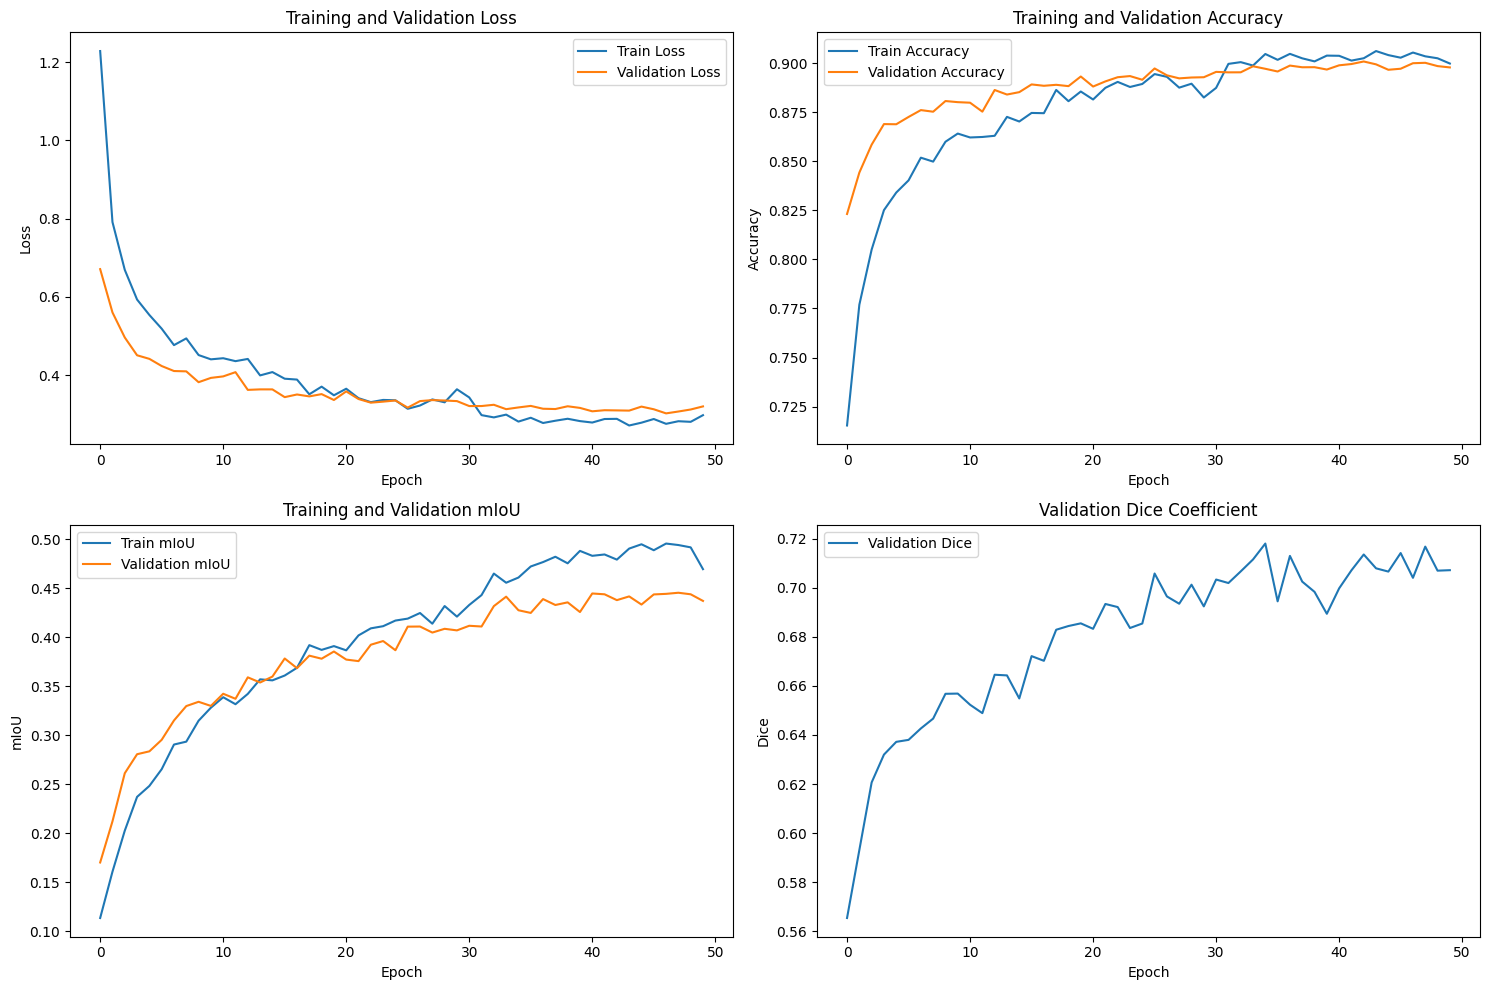

In [42]:
plot_training_history(history)

In [27]:
import json

In [28]:
def save_history_to_json(history, filename=None):
    os.makedirs('training_history', exist_ok=True)
    filepath = os.path.join('training_history', filename)

    serializable_history = {}
    for key, value in history.items():
        if isinstance(value, (list, np.ndarray)):
            serializable_history[key] = [float(x) for x in value]
        else:
            serializable_history[key] = value

    with open(filepath, 'w') as f:
        json.dump(serializable_history, f, indent=4)

    print(f"История обучения сохранена в {filepath}")
    return filepath

In [46]:
save_history_to_json(history, filename=f"try-{datetime.now()}.json")

История обучения сохранена в training_history/try-2025-05-23 16:40:27.707458.json


'training_history/try-2025-05-23 16:40:27.707458.json'

In [30]:
torch.save(model.state_dict(), "fcn_resnet50_32cl.pth")

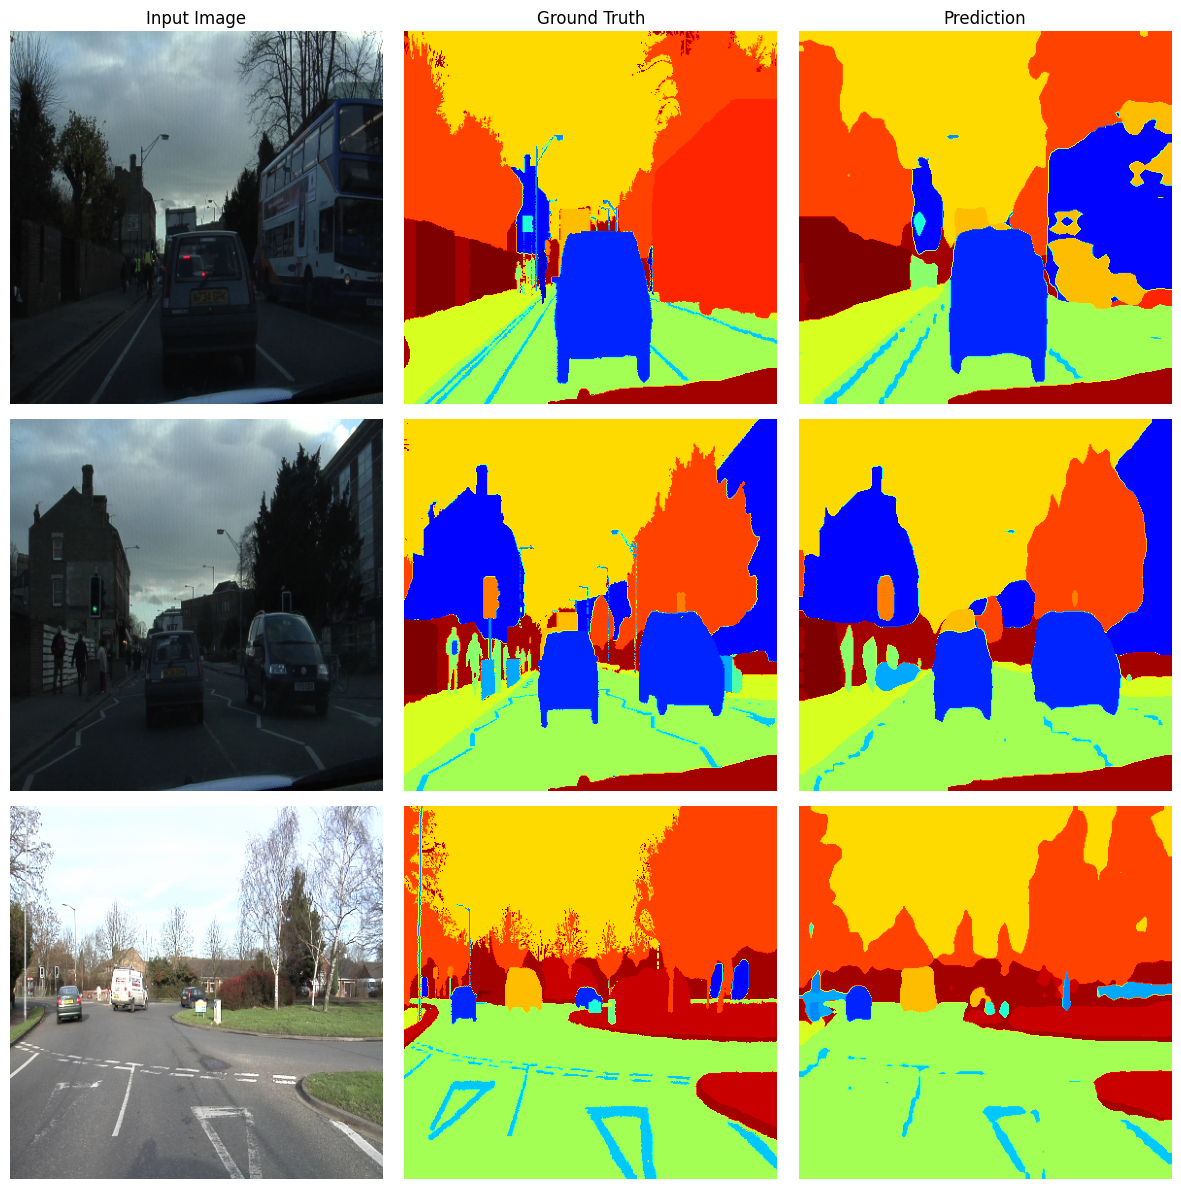

In [47]:
def plot_results(model, dataloader, num_samples=3):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 4))
    axes[0, 0].set_title("Input Image")
    axes[0, 1].set_title("Ground Truth")
    axes[0, 2].set_title("Prediction")

    with torch.no_grad():
        for i, (images, masks) in enumerate(dataloader):
            if i >= num_samples:
                break
            images = images.to("cuda")
            masks = masks.cpu().numpy()
            outputs = model(images)["out"]
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            img = images[0].cpu().permute(1, 2, 0).numpy()
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)

            axes[i, 0].imshow(img)
            axes[i, 1].imshow(masks[0], cmap="jet", vmin=0, vmax=31)
            axes[i, 2].imshow(preds[0], cmap="jet", vmin=0, vmax=31)

            for ax in axes[i]:
                ax.axis("off")

    plt.tight_layout()
    plt.show()

plot_results(model, val_loader, num_samples=3)

In [48]:
# После обучения модели
test_loss, test_acc, test_iou_per_class, test_mean_iou, test_dice_per_class, test_mean_dice = val_epoch(
    model, test_loader, criterion, device
)

print(f"Test Results:")
print(f"Loss: {test_loss:.4f} | Accuracy: {test_acc:.4f} | mIoU: {test_mean_iou:.4f} | Dice: {test_mean_dice:.4f}")

Validating: 100%|██████████| 58/58 [00:20<00:00,  2.88it/s, val_loss=0.6053]

Test Results:
Loss: 0.4055 | Accuracy: 0.8773 | mIoU: 0.3935 | Dice: 0.6915
